In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

test_read = pd.read_parquet('C:/Users/np188211/OneDrive - GSK/Documents/Hack Nov 2022/Day 2/data_day2/complete_oai_data_test_unlabelled.parquet', engine='pyarrow')
train_read = pd.read_parquet('C:/Users/np188211/OneDrive - GSK/Documents/Hack Nov 2022/Day 2/data_day2/complete_oai_data_train.parquet', engine='pyarrow')

train=train_read.copy()
test=test_read.copy()
test_id = test.copy()


C:\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
train = train[train['visit']==0]
test = test.drop(['newstrata','id','side','comments','technical'],axis=1)

In [3]:
X = train[(train.columns) & (test.columns)]
test = test[(train.columns) & (test.columns)]

X = X.fillna({'reader':'none'})
test = test.fillna({'reader':'none'})

y= train.surgery_on_this_knee_within_5_years

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """Entry point for launching an IPython kernel.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  


In [4]:
from sklearn.metrics import recall_score,make_scorer,matthews_corrcoef
mat = make_scorer(matthews_corrcoef, greater_is_better=True)

In [5]:
from lightgbm import LGBMClassifier

#X,y=df.drop(['surgery_same_side_as_MRI'],axis=1),df.surgery_same_side_as_MRI

#objects=X.select_dtypes('object').columns.to_list()

objects = ['reader']
for col in objects:
            X[col] = X[col].astype('category')
            test[col] = test[col].astype('category')

categorical_features_indices = np.where(X.dtypes =='object')[0]


lgbm = LGBMClassifier(categorical_features = categorical_features_indices,random_state=13,
                      metric='mat',is_unbalance = True)

lgbm.fit(X,y)
pred_l = lgbm.predict(test)

C:\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_features in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [6]:
pred_l.mean()

0.206266318537859

In [14]:
from catboost import CatBoostClassifier,Pool, cv,CatBoostRegressor

categorical_features_indices = np.where(X.dtypes =='category')[0]
catb = CatBoostClassifier(cat_features=categorical_features_indices,random_seed=13,auto_class_weights='Balanced',verbose=0)
#,loss_function=mat,eval_metric = mat
catb.fit(X, y)
pred_c = catb.predict(test)

In [8]:
pred_c.mean()

0.2297650130548303

In [9]:
import xgboost as xgb


# train = train_read.copy()
# test = test_read.copy()
# train = train[train['visit']==0]
# test = test.drop(['id','side','comments','technical'],axis=1)
X = train[(train.columns) & (test.columns)].drop(['reader'],axis=1)
test = test[(train.columns) & (test.columns)].drop(['reader'],axis=1)
y= train.surgery_on_this_knee_within_5_years

xg = xgb.XGBClassifier(eval_metric= mat,nthread=-1,scale_pos_weight=2.57,feval = mat)          
xg.fit(X,y)
pred_x = xg.predict(test)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if __name__ == '__main__':


In [10]:
pred_x.mean()

0.19843342036553524

In [11]:
ens = np.round(np.mean([pred_c, pred_x, pred_l], axis=0))
ens.mean()

0.19321148825065274

In [12]:
predicted = pd.read_csv('C:/Users/np188211/OneDrive - GSK/Documents/Hack Nov 2022/Day 2/data_day2/predicted.csv')

index=pd.DataFrame({'id':test_id.id})
results=pd.DataFrame(ens.reshape(-1,1)) 
out=index.merge(results,left_index=True,right_index=True)
out.columns=['ID','surgery_on_this_knee_within_5_years']
out
out.to_csv('C:/Users/np188211/OneDrive - GSK/Documents/Hack Nov 2022/Day 2/data_day2/Ensemble.csv',index=False)

Feature Importance LGBM

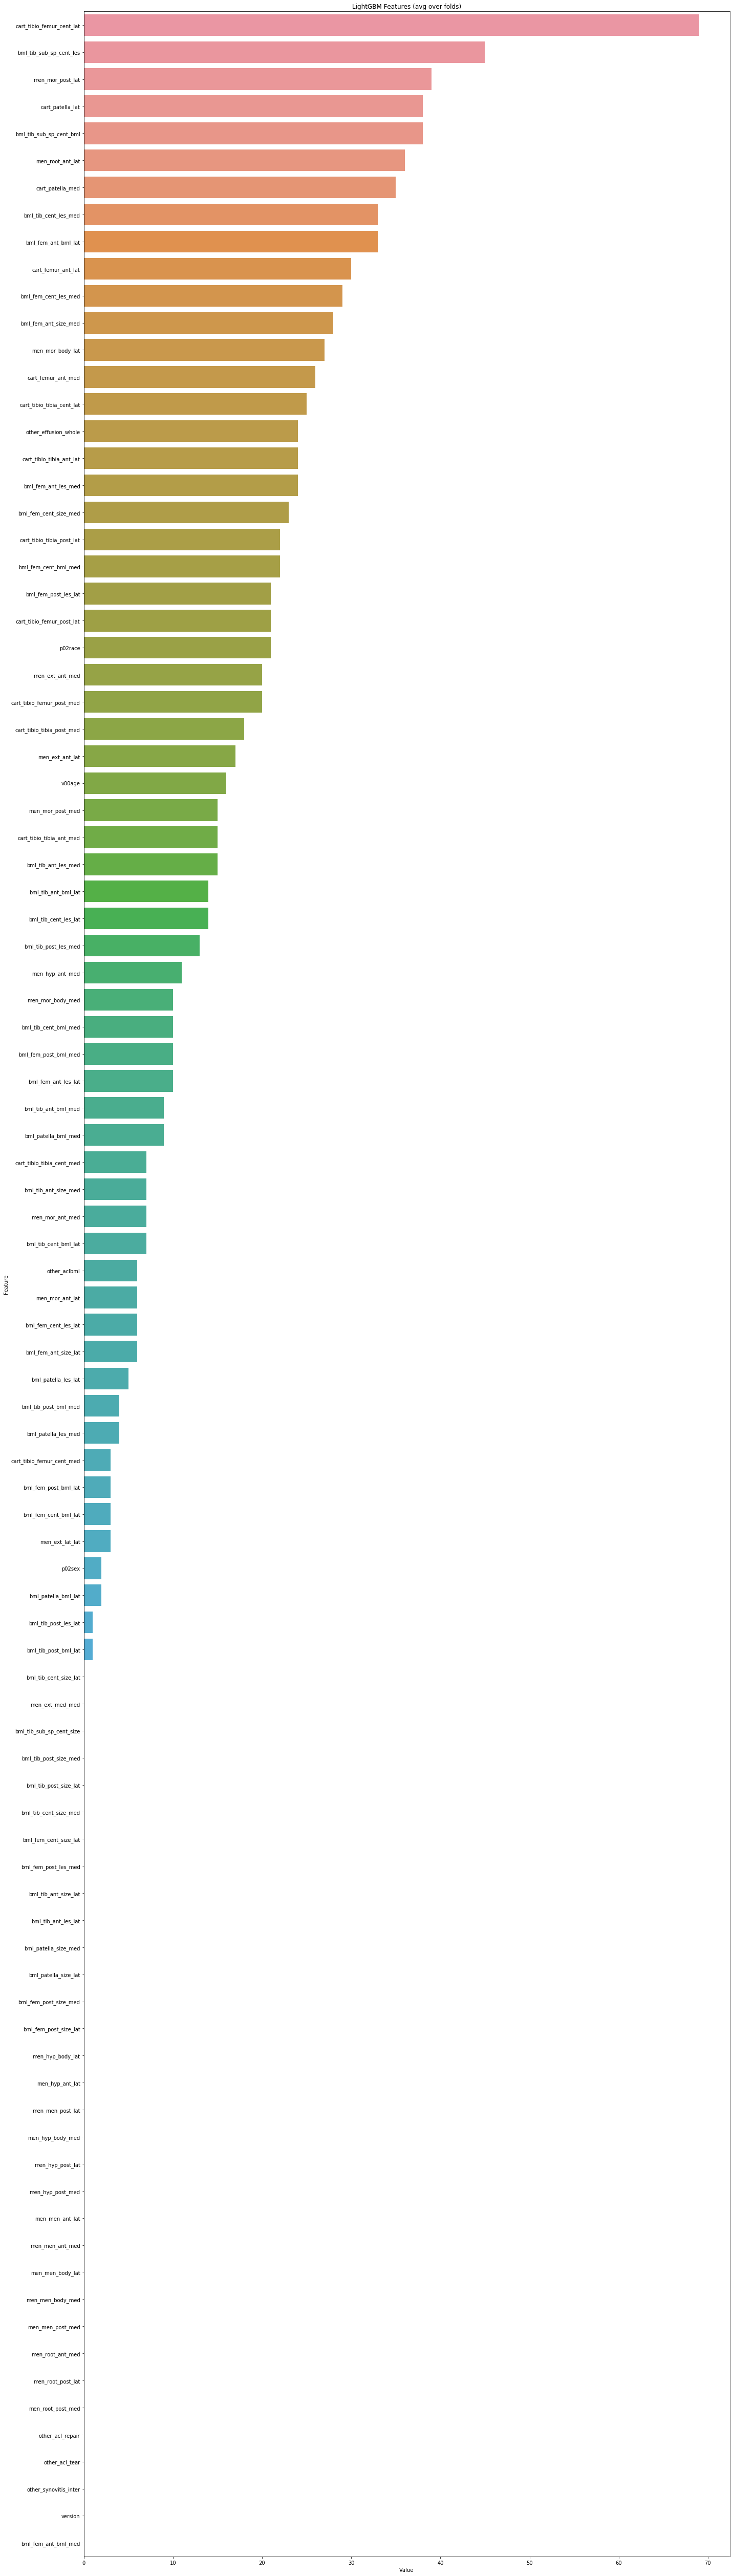

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 70))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()